In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Gerekli kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

# Uyarıları kapatma
warnings.filterwarnings('ignore')

# GPU kullanılabilirliğinin kontrolü
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


**Veri Klasörlerini Listeleme**

Bu kod, veri setindeki klasörleri ve her klasördeki dosya sayısını listeler.
Amacı, veri yapısını ve sınıf dağılımını gözlemlemektir.

In [4]:
# Veri klasörlerini listele
base_dir = "/kaggle/input/concrete-crack-images-for-classification"
for dirname, _, filenames in os.walk(base_dir):
    print(dirname, len(filenames))

/kaggle/input/concrete-crack-images-for-classification 0
/kaggle/input/concrete-crack-images-for-classification/Negative 20000
/kaggle/input/concrete-crack-images-for-classification/Positive 20000


# Beton Yüzeylerde Çatlak Tespiti - CNN ile Görüntü Sınıflandırma

## 1. Veri Önişleme ve Görselleştirme

Bu aşamada:
- Görselleri **150x150** boyutuna getiriyoruz.
- Eğitim ve doğrulama setlerine ayırıyoruz (80% - 20%).
- **Data Augmentation** (rotation, shift, zoom, flip) ile veriyi zenginleştiriyoruz.
- Örnek görselleri çizdirerek çeşitliliği gözlemliyoruz.

In [5]:
# ImageDataGenerator ile veri yükleme ve augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # pikselleri 0-255 aralığından 0-1 aralığına ölçekliyor
    rotation_range=20,           # resimleri ±20 dereceye kadar döndürüyor
    width_shift_range=0.2,       # resimleri yatayda %20’ye kadar kaydırıyor
    height_shift_range=0.2,      # resimleri dikeyde %20’ye kadar kaydırıyor
    zoom_range=0.2,              # resmi %20 oranında yakınlaştırıp uzaklaştırabiliyor
    horizontal_flip=True,        # resmi yatayda ayna çeviriyor
    validation_split=0.2         # verinin %20’sini doğrulama (validation) için ayırıyor
)

train_generator = train_datagen.flow_from_directory(
    base_dir,                # Resimlerin bulunduğu ana klasör
    target_size=(150, 150),  # Her resmi 150x150 boyutuna çevir
    batch_size=32,           # 32 resmi aynı anda modele ver
    class_mode='binary',     # Çatlak var mı / yok mu (0-1 şeklinde etiketler)
    subset='training'        # Verilerin %80’ini eğitim için ayır
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'      # Verilerin %20’sini doğrulama için ayır
)


Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


### Örnek Görseller

Train setinden rastgele örnekler seçip görselleştiriyoruz.
Bu sayede veri setinin çeşitliliğini ve augmentasyon etkilerini gözlemleyebiliriz.

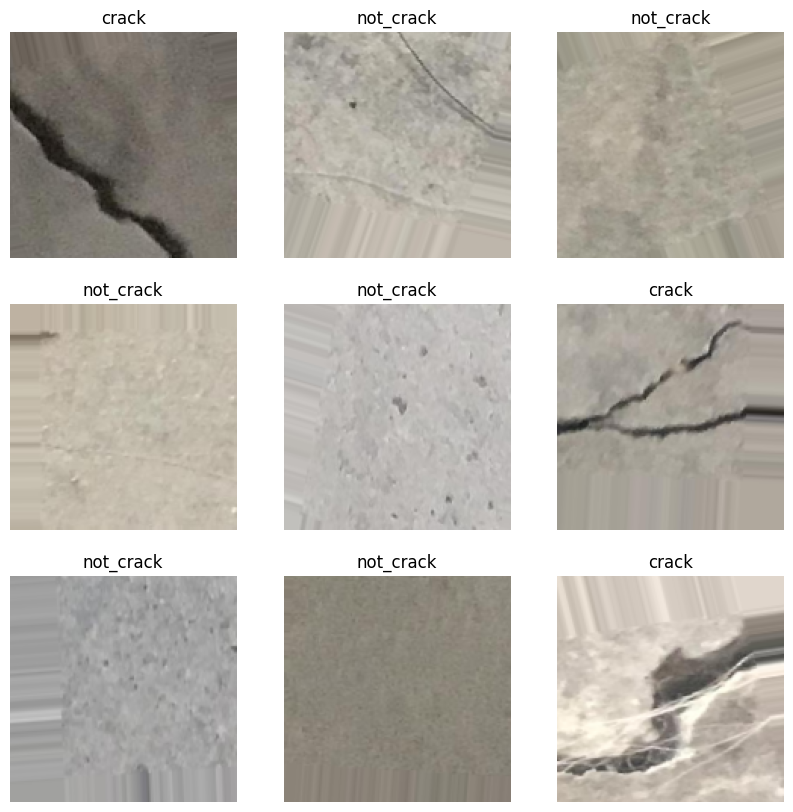

In [12]:
# Label map: 0 → not_crack, 1 → crack
label_map = {0: 'not_crack', 1: 'crack'}
    
# train_generator’dan bir batch veri al
x_batch, y_batch = next(train_generator)

# İlk 9 resmi çiz
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(label_map[int(y_batch[i])])  # Etiketi okunabilir isimle göster
    plt.axis('off')
plt.show()


### Sınıf Dağılımı

Her sınıftaki örnek sayısını görselleştirerek veri setinin dengeli olup olmadığını kontrol ediyoruz.

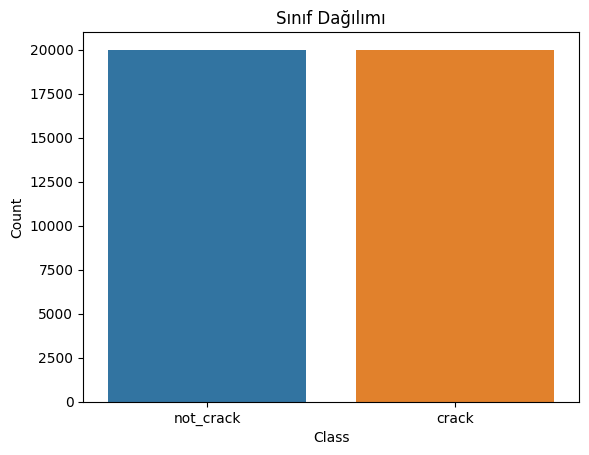

In [7]:
# Label map
label_map = {'Negative': 'not_crack', 'Positive': 'crack'}

# DataFrame oluştur
class_counts = pd.DataFrame(list(train_generator.class_indices.items()), columns=['Class', 'Index'])
class_counts['Class'] = class_counts['Class'].map(label_map)  # isimleri değiştir
class_counts['Count'] = [len(os.listdir(os.path.join(base_dir, cls))) for cls in train_generator.class_indices]
sns.barplot(x='Class', y='Count', data=class_counts)
plt.title('Sınıf Dağılımı')
plt.show()


# 3. Modelin Eğitilmesi

Bu bölümde beton yüzeylerindeki çatlakların sınıflandırılması için **CNN (Convolutional Neural Network)** tabanlı bir model oluşturulacaktır.  
Modelde kullanılan temel bileşenler şunlardır:

- **Convolutional Layers (Conv2D):** Görsellerden kenar, köşe, desen gibi özellikleri çıkarır.
- **Pooling Layers (MaxPooling2D):** Özellik haritalarını küçülterek daha verimli hale getirir.
- **Dropout:** Ezberlemeyi (overfitting) önlemek için nöronları rastgele kapatır.
- **Dense (Fully Connected) Layers:** Özelliklerden yola çıkarak sınıflandırma yapar.
- **Aktivasyon Fonksiyonları:**
  - Ara katmanlarda: **ReLU**
  - Çıkış katmanında: **Sigmoid** (binary classification için)


In [9]:
# 3. MODELİN OLUŞTURULMASI
# Bu aşamada CNN tabanlı bir model oluşturacağız.

from tensorflow.keras import layers, models

def create_cnn_model():
    model = models.Sequential([
        # 1. Evrişim Bloğu
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # 2. Evrişim Bloğu
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # 3. Evrişim Bloğu
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Sınıflandırıcı (Flatten + Dense katmanlar)
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')   # Binary classification için çıkış katmanı
    ])
    return model

# Modeli oluştur
cnn_model = create_cnn_model()

# Model özetini göster
cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,329 (20.61 MB)

 Trainable params: 5,402,625 (20.61 MB)

 Non-trainable params: 704 (2.75 KB)

### Modelin Derlenmesi

Model, **Adam** optimizasyon algoritması ve **Binary Crossentropy** kayıp fonksiyonu ile derlenmiştir.  
Başarı metriği olarak **accuracy (doğruluk)** kullanılmıştır.


Epoch 1/20


I0000 00:00:1758784867.933502     118 service.cc:148] XLA service 0x7a6950009de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758784867.934476     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758784867.934503     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758784868.630624     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1000 ━━━━━━━━━━━━━━━━━━━━ 3:51:25 14s/step - accuracy: 0.3750 - loss: 0.9892

I0000 00:00:1758784876.033141     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 368s 354ms/step - accuracy: 0.9540 - loss: 0.1342 - val_accuracy: 0.9874 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 284s 284ms/step - accuracy: 0.9865 - loss: 0.0458 - val_accuracy: 0.7186 - val_loss: 1.0534 - learning_rate: 0.0010
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 285s 285ms/step - accuracy: 0.9881 - loss: 0.0398 - val_accuracy: 0.8235 - val_loss: 0.7596 - learning_rate: 0.0010
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 274s 274ms/step - accuracy: 0.9885 - loss: 0.0393 - val_accuracy: 0.9669 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 272s 272ms/step - accuracy: 0.9911 - loss: 0.0304 - val_accuracy: 0.9949 - val_loss: 0.0230 - learning_rate: 2.0000e-04
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 258s 258ms/step - accuracy: 0.9924 - loss: 0.0271 - val_accuracy: 0.9961 - val_loss: 0.0189 - learning_rate: 2.0000e-04
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 241s 241ms/st

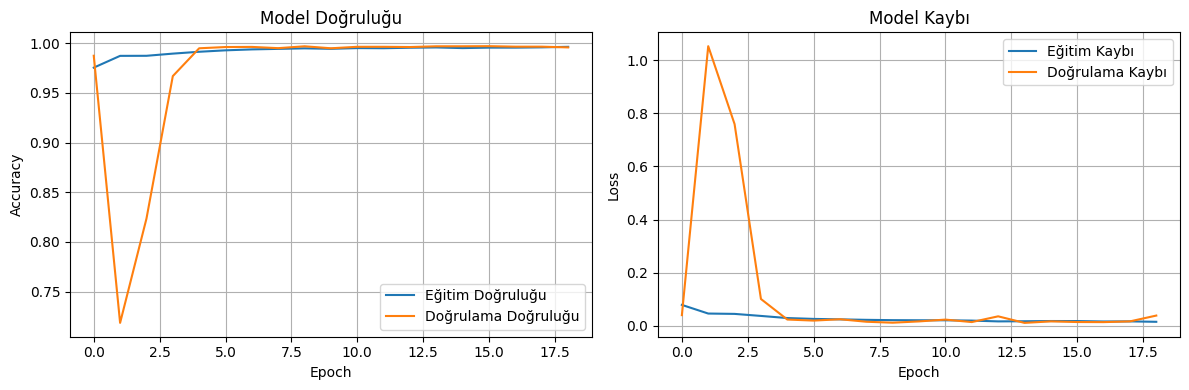

250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step


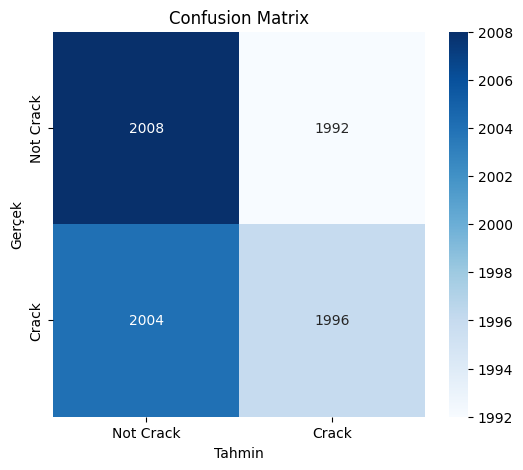

              precision    recall  f1-score   support

   Not Crack       0.50      0.50      0.50      4000
       Crack       0.50      0.50      0.50      4000

    accuracy                           0.50      8000
   macro avg       0.50      0.50      0.50      8000
weighted avg       0.50      0.50      0.50      8000



In [10]:
# 4. MODELİN DERLENMESİ VE EĞİTİLMESİ

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Modeli compile edelim
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',   # Binary classification
    metrics=['accuracy']
)

# Callbacks tanımlayalım
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Modeli eğitelim
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Eğitim ve doğrulama grafiklerini çizelim
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix ve Classification Report
y_true = validation_generator.classes
y_pred_prob = cnn_model.predict(validation_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Crack','Crack'], yticklabels=['Not Crack','Crack'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Not Crack','Crack']))


## 6. Örnek Tahmin Görselleri
Modelin görseller üzerinde nasıl çalıştığını görmek için doğrulama setinden bazı örnekler seçiyoruz.  
Her resmin altında **Gerçek Etiket** ve **Tahmin** bilgisi gösterilir.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


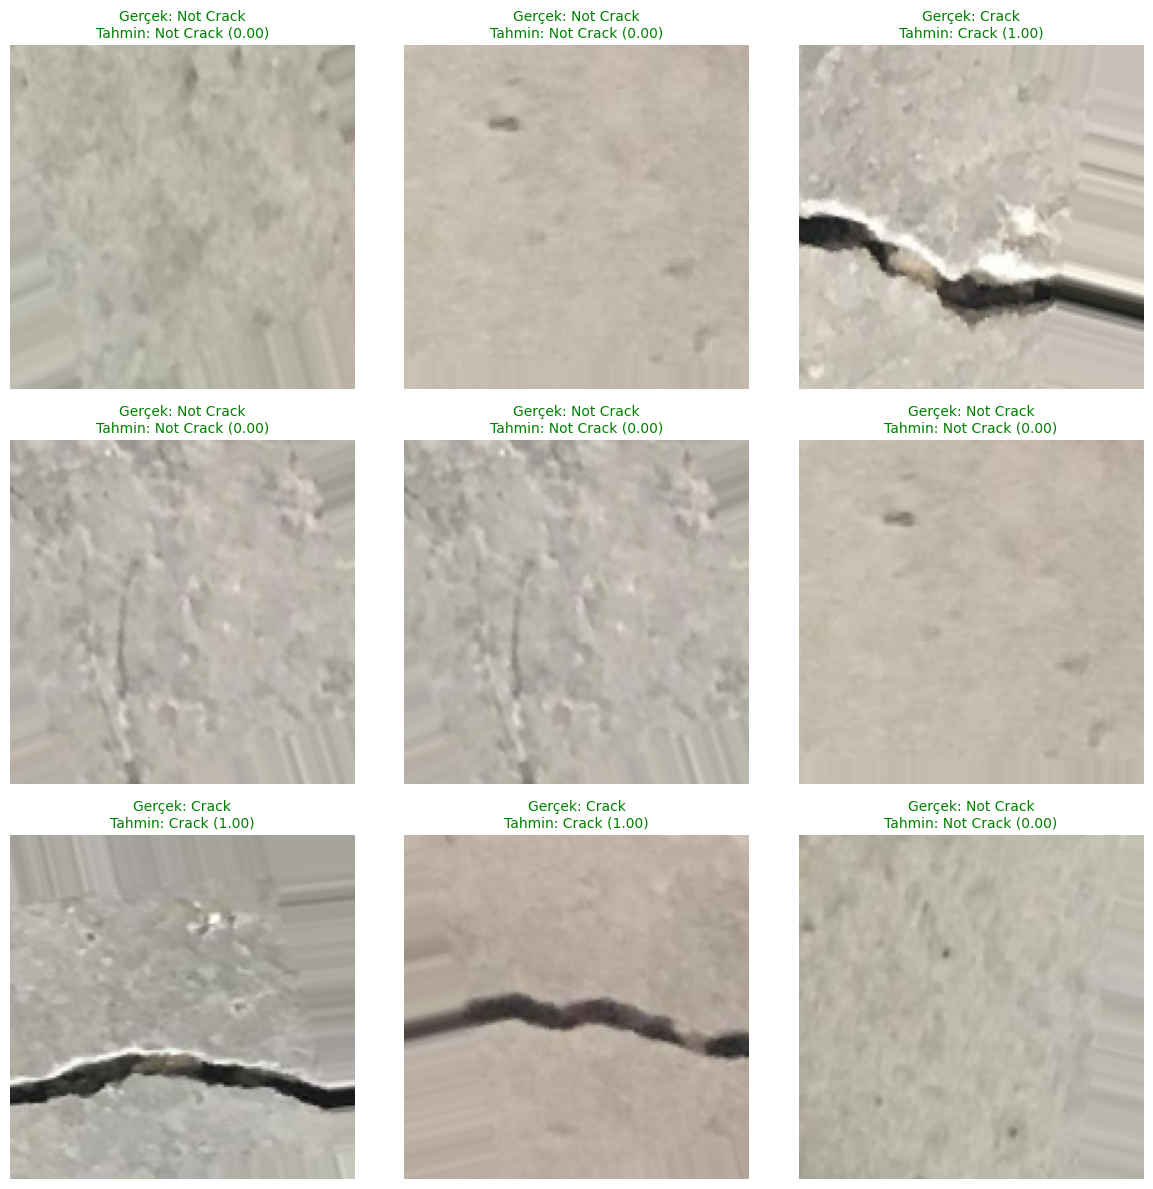

In [13]:
import random

# Validation setinden rastgele örnekler seçelim
x_val, y_val = next(validation_generator)

plt.figure(figsize=(12, 12))

for i in range(9):
    idx = random.randint(0, len(x_val)-1)
    img = x_val[idx]
    true_label = 'Crack' if y_val[idx] == 1 else 'Not Crack'
    
    # Model tahmini
    pred_prob = cnn_model.predict(img[np.newaxis, ...])[0][0]
    pred_label = 'Crack' if pred_prob > 0.5 else 'Not Crack'
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label} ({pred_prob:.2f})",
              fontsize=10, color=("green" if true_label==pred_label else "red"))

plt.tight_layout()
plt.show()
